# Faktoryzacja QR

In [264]:
import numpy as np
from sklearn.preprocessing import normalize
from scipy import linalg
import matplotlib.pyplot as plt

### Algorytm Grama-Schmidta

In [315]:
def Gram_Schmidt(M):
    n = M.shape[0]
    Q = np.copy(M)
    R = np.zeros((n, n))
    for i in range(n):
        scalars = M[:,i]@Q[:,:i]
        delta = np.sum(scalars*Q[:,:i], axis=1, keepdims=True)
        Q[:,i:i+1]-=delta
        Q[:,i:i+1] = normalize(Q[:,i:i+1], axis=0)
        R[:i,i] = scalars.T
        R[i, i] = np.dot(Q[:,i], M[:,i])
    return Q, R

In [97]:
def get_random_matrix(N):
    return np.random.rand(N, N)

In [122]:
for N in [50, 100, 150, 200]:
    M = get_random_matrix(N)
    %timeit Gram_Schmidt(M)
    Q, R = Gram_Schmidt(M)
    %timeit np.linalg.qr(M)
    Q_lib, R_lib = np.linalg.qr(M)
    print(f'N={N}, Q@R==M: {np.allclose(Q@R, M)}, Proper Q: {np.allclose(np.abs(Q), np.abs(Q_lib))}, Proper R: {np.allclose(np.abs(R), np.abs(R_lib))}')

5.95 ms ± 217 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
191 µs ± 2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
N=50, Q@R==M: True, Proper Q: True, Proper R: True
13.1 ms ± 65.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
511 µs ± 3.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
N=100, Q@R==M: True, Proper Q: True, Proper R: True
24.6 ms ± 416 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.05 ms ± 7.64 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
N=150, Q@R==M: True, Proper Q: True, Proper R: True
41.8 ms ± 3.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.04 ms ± 345 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
N=200, Q@R==M: True, Proper Q: True, Proper R: True


### Wpływ wskaźnika uwarunkowania macierzy

In [279]:
def get_ill_conditioned_matrix(N, cond):
    M = get_random_matrix(N)
    S, V, D = np.linalg.svd(M)
    V[0]*=(cond*V[-1]/V[0])
    return S@linalg.diagsvd(V, N, N)@D

def check(Q):
    return np.max(np.abs(np.identity(Q.shape[0])-Q.T@Q))    
    #return np.linalg.norm(np.identity(Q.shape[0])-Q.T@Q)

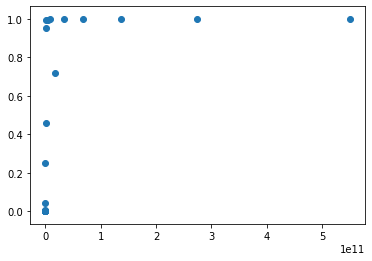

In [280]:
conds = [2**i for i in range(40)]
comp = []
for c in conds:
    M = get_ill_conditioned_matrix(8, c)
    Q, R = Gram_Schmidt(M)
    comp.append(check(Q))

plt.scatter(conds, comp)

Obserwujemy utratę ortogonalności macierzy $Q$ w miarę zwiększania się wskaźnika uwarunkowania macierzy. Przyczyną jest poniższa zależność, wspomniana między innymi [tutaj](https://pdfs.semanticscholar.org/3809/cbb4bea1c91d05c80fb5edb8e2890555e342.pdf): $$||I-Q^TQ||<c\epsilon \kappa _2 (A)$$ gdzie $\epsilon$-precyzja obliczeń numerycznych, $\kappa _2(A)$ - wskaźnik uwarunkowania macierzy $A$. Duża wartość wskaźnika uwarunkowania macierzy sprawia, algorytm Grama-Schmidta staje się numerycznie niestabilny i zalezność $I=Q^TQ$ specyficzna dla macierzy ortogonalnych przestaje obowiązywać.

# Rozwiązywanie układów równań metodą QR

In [320]:
X = [-5.+i for i in range(11)]
Y = np.array([2., 7., 9., 12., 13., 14., 14., 13., 10., 8., 4.])
A = np.array([[1, x, x*x] for x in X])

In [325]:
def least_squares(A, Y):
    Q, R = Gram_Schmidt(A.T@A)
    return linalg.solve_triangular(R, Q.T@A.T@Y)

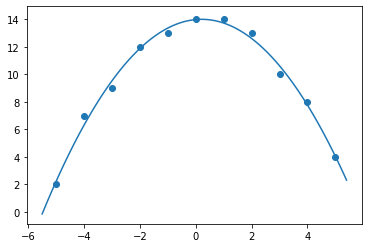

In [332]:
W = least_squares(A, Y.T)
X_s = np.arange(-5.5, 5.5, 0.1)
Y_s = [W[0]+W[1]*x+W[2]*x*x for x in X_s]
plt.plot(X_s, Y_s)
plt.scatter(X, Y)